# Experience sklearn built-in SVM

In [16]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sets the backend of matplotlib to the 'inline' backend.
#
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
# directly below the code cell that produced it.
# The resulting plots will then also be stored in the notebook document.
#
# More details: https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline
%matplotlib inline

from scipy.io import loadmat

raw_data = loadmat(os.getcwd() + '/linear_discriminable_samples.mat')
raw_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:28:43 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[1.9643  , 4.5957  ],
        [2.2753  , 3.8589  ],
        [2.9781  , 4.5651  ],
        [2.932   , 3.5519  ],
        [3.5772  , 2.856   ],
        [4.015   , 3.1937  ],
        [3.3814  , 3.4291  ],
        [3.9113  , 4.1761  ],
        [2.7822  , 4.0431  ],
        [2.5518  , 4.6162  ],
        [3.3698  , 3.9101  ],
        [3.1048  , 3.0709  ],
        [1.9182  , 4.0534  ],
        [2.2638  , 4.3706  ],
        [2.6555  , 3.5008  ],
        [3.1855  , 4.2888  ],
        [3.6579  , 3.8692  ],
        [3.9113  , 3.4291  ],
        [3.6002  , 3.1221  ],
        [3.0357  , 3.3165  ],
        [1.5841  , 3.3575  ],
        [2.0103  , 3.2039  ],
        [1.9527  , 2.7843  ],
        [2.2753  , 2.7127  ],
        [2.3099  , 2.9584  ],
        [2.8283  , 2.6309  ],
        [3.0473  , 2.2931  ],
        [2.4827  , 2.0373  ],
        [2.5057 

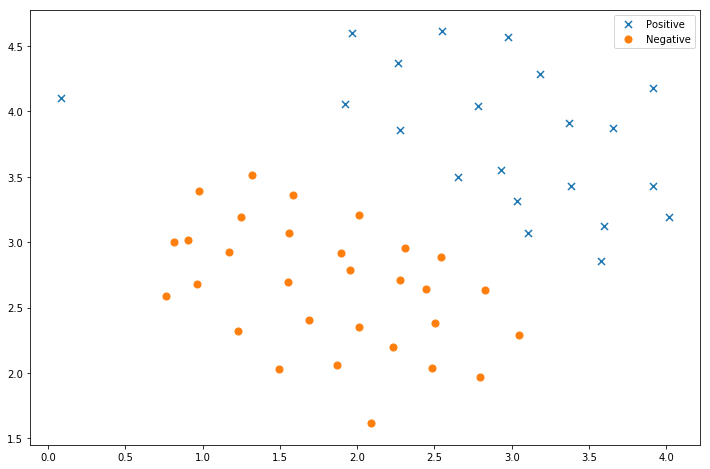

In [17]:
data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]  
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='Positive')  
ax.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='Negative')  
ax.legend() 

### SVM with linear kernel (`C=1` vs `C=100`)

In [18]:
from sklearn import svm

svc1 = svm.LinearSVC(C=1, loss='hinge', max_iter=1000)  
svc1

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [19]:
svc1.fit(data[['X1', 'X2']], data['y'])  
svc1.score(data[['X1', 'X2']], data['y'])

0.9803921568627451

In [20]:
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)  
svc2.fit(data[['X1', 'X2']], data['y'])  
svc2.score(data[['X1', 'X2']], data['y']) 

1.0

Text(0.5, 1.0, 'SVM (C=1) Decision Confidence')

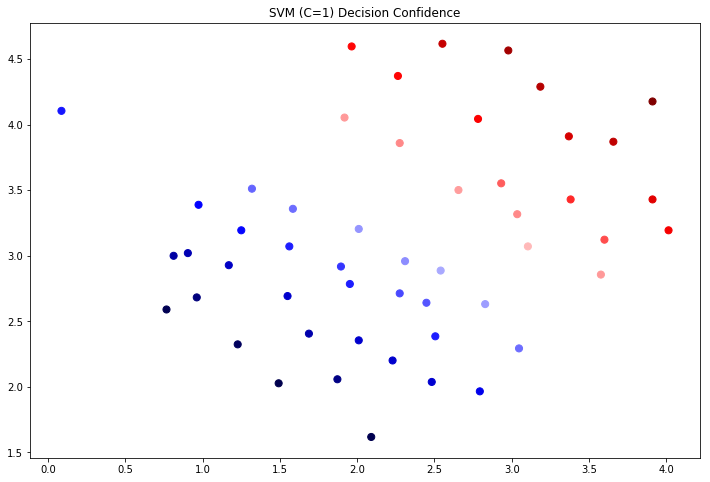

In [21]:
data['SVM 1 Confidence'] = svc1.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 1 Confidence'], cmap='seismic')  
ax.set_title('SVM (C=1) Decision Confidence')

Text(0.5, 1.0, 'SVM (C=100) Decision Confidence')

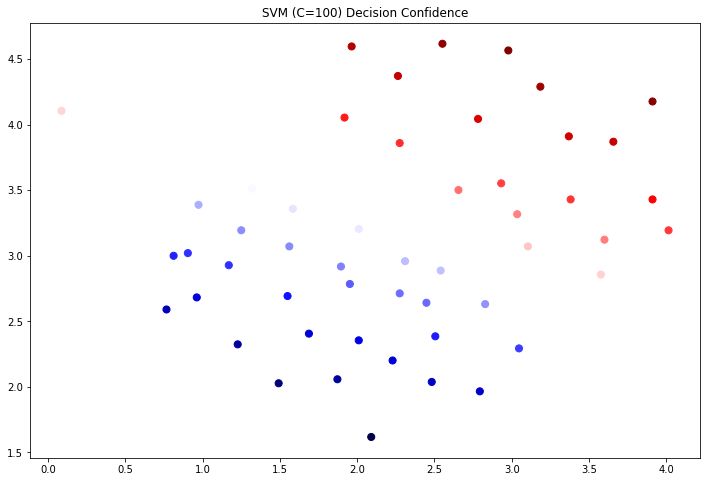

In [22]:
data['SVM 2 Confidence'] = svc2.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 2 Confidence'], cmap='seismic')  
ax.set_title('SVM (C=100) Decision Confidence')

### SVM with gaussian kernel (built-in by sklearn already)

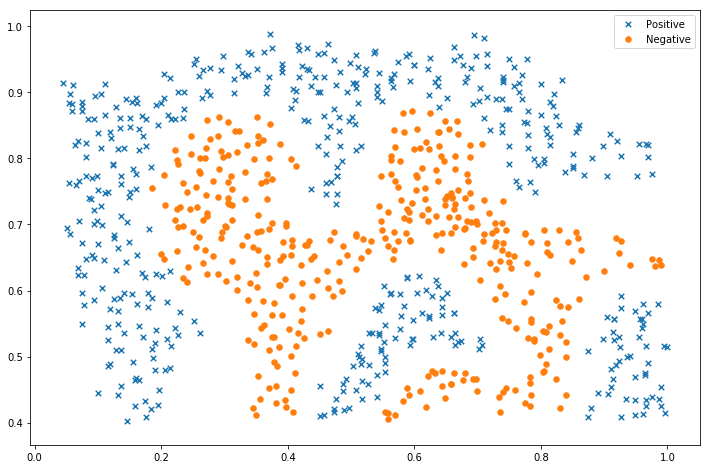

In [50]:
raw_data = loadmat(os.getcwd() + '/nonlinear_discriminable_samples.mat')

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])  
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]  
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['X1'], positive['X2'], s=30, marker='x', label='Positive')  
ax.scatter(negative['X1'], negative['X2'], s=30, marker='o', label='Negative')  
ax.legend()

#### Here just demostrate a way how to use a custom kernel with some dynamic values, like the `sigma` here

In [51]:
def build_gaussian_kernel(sigma):
    def gaussian_kernel(x1, x2):
        return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))
    return gaussian_kernel
# Then: svc = svm.SVC(C=100, kernel=build_gaussian_kernel(sigma=1), gamma=10, probability=True)

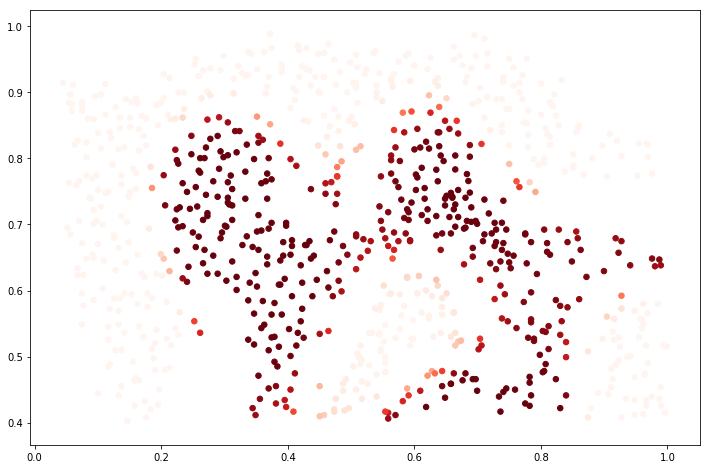

In [113]:
svc = svm.SVC(C=100, kernel='rbf', gamma=10, probability=True)
svc.fit(data[['X1', 'X2']], data['y'])  
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'], cmap='Reds')

In [117]:
from sklearn import base
from sklearn import model_selection
from sklearn import ensemble

raw_data = loadmat(os.getcwd() + '/samples_contain_both_training_and_validation_set.mat')

X = np.concatenate((raw_data['X'], raw_data['Xval']), axis=0)
y = np.concatenate((raw_data['y'].ravel(), raw_data['yval'].ravel()))

test_fold = np.concatenate((np.full(raw_data['X'].shape[0], 0), np.full(raw_data['Xval'].shape[0], -1)))
ps = model_selection.PredefinedSplit(test_fold)

param_candidates = [
    {
        'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
        'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
        'kernel': ['rbf']
    }
]

clf = model_selection.GridSearchCV(
    estimator=svm.SVC(),
    param_grid=param_candidates,
    cv=ps,
    refit=True,
    error_score=0,
    n_jobs=-1
)

clf.fit(X, y)
clf.best_estimator_


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)